### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

### Carregamento dos dados

In [2]:
dataOriginal = pd.read_csv('new_Global_Superstore2.csv', index_col=0, comment='#') 
df = dataOriginal 

### Tratamento dos dados

In [3]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
'''
Links:
https://stackoverflow.com/questions/44552031/sklearnstandardscaler-can-i-inverse-the-standardscaler-for-the-model-output
https://stackoverflow.com/questions/56936780/how-do-i-correctly-use-the-inverse-transform-method-when-using-powertransformer
'''

y = dataOriginal[['Profit']]
df = dataOriginal

ss = StandardScaler()

ss.fit(df)
df = pd.DataFrame(ss.transform(df))

ss_y = StandardScaler()
ss_y.fit(y)
y = pd.DataFrame(ss_y.transform(y))
#y = ss_y.inverse_transform(pd.DataFrame(y))

pt = PowerTransformer()
pt.fit(df)
#df = pt.transform(df)
df = pd.DataFrame(pt.transform(df))

pt_y = PowerTransformer()
pt_y.fit(y)
#df = pt.transform(df)
y = pd.DataFrame(pt_y.transform(y))
#y = pt_y.inverse_transform(pd.DataFrame(y))


scaler = MinMaxScaler(feature_range = (0,1))
df = pd.DataFrame(scaler.fit_transform(df))

scaler_y = MinMaxScaler(feature_range = (0,1))
y = scaler_y.fit_transform(y)


def unscale(value):
    value_res = value
    value_res = scaler_y.inverse_transform(pd.DataFrame(value_res))
    value_res = pt_y.inverse_transform(pd.DataFrame(value_res))
    value_res = ss_y.inverse_transform(pd.DataFrame(value_res))
 
    return value_res




### Neurónios

In [4]:
#dataset_MLP = dataset.drop(columns=['Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Postal Code'])


#dataset_MLP = dataset_MLP.drop(['Order Priority', 'Market', "City", "Segment", "Ship Mode", "Ship Date"], axis=1)
#print(dataset_MLP.info())

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn

RANDOM_SEED = 2021

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


In [6]:
dataset_MLP = df

X_MLP = dataset_MLP.drop(8, axis=1)
y_MLP = dataset_MLP[[8]]

small_dataset = False
if small_dataset: 
    remove_n = 40000
    drop_indices = np.random.choice(dataset_MLP.index, remove_n, replace=False)
    dataset_MLP_subset = dataset_MLP.drop(drop_indices)
    X_MLP = dataset_MLP_subset.drop(8, axis=1)
    y_MLP = dataset_MLP_subset[[8]]


In [7]:

# Onde fui buscar algumas coisas:
# https://www.projectpro.io/recipes/find-optimal-parameters-using-gridsearchcv


X_train, X_test, y_train, y_test = train_test_split(X_MLP, y_MLP, test_size=0.2, random_state=RANDOM_SEED)

number_columns = len(X_train.columns)#.count()
#print("Número de colunas: ", number_columns)

def build_model(activation='relu', learning_rate=0.01):
#create a sequential model (with three Layers - Last one is the output)
    model = Sequential()
    model.add(Dense(number_columns, input_dim=number_columns, activation=activation))
    model.add(Dense(6, activation=activation))
    model.add(Dense(1, activation='relu'))
  
     #compile the model
    #Define the Loss function, the otimizer and metrics to be used
    model. compile(
        loss = 'mse',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['mse'])
    return model

model = build_model()
model.summary()


TUNING_DICT = {'learning_rate': [0.01,0.03, 0.1],                  
                'activation' : ['relu', 'sigmoid'],
                 }

kf = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)
grid_search = GridSearchCV(estimator = model,
                            param_grid = TUNING_DICT,
                            cv = kf,
                            scoring = 'neg_mean_squared_error',
                            refit ='True',
                            verbose = 1)

grid_search.fit(X_train, y_train, validation_split=0.2)

print(" Results from Grid Search " )
print(grid_search)
#print("\n The best score across ALL searched params:\n",grid_search.best_score_)
#print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 22)                506       
                                                                 
 dense_1 (Dense)             (None, 6)                 138       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________
Fitting 2 folds for each of 6 candidates, totalling 12 fits


C:\Users\Diogo\AppData\Local\Temp\ipykernel_15144\309049736.py:35: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)


Epoch 1/15
745/745 [==============================] - 5s 4ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 1.5217e-04 - val_mse: 1.5217e-04
Epoch 2/15
745/745 [==============================] - 3s 3ms/step - loss: 1.5829e-04 - mse: 1.5829e-04 - val_loss: 1.4428e-04 - val_mse: 1.4428e-04
Epoch 3/15
745/745 [==============================] - 3s 4ms/step - loss: 1.4584e-04 - mse: 1.4584e-04 - val_loss: 9.6446e-05 - val_mse: 9.6446e-05
Epoch 4/15
745/745 [==============================] - 3s 4ms/step - loss: 1.3054e-04 - mse: 1.3054e-04 - val_loss: 6.9926e-05 - val_mse: 6.9926e-05
Epoch 5/15
745/745 [==============================] - 2s 3ms/step - loss: 1.2379e-04 - mse: 1.2379e-04 - val_loss: 7.3792e-05 - val_mse: 7.3792e-05
Epoch 6/15
745/745 [==============================] - 2s 3ms/step - loss: 1.2192e-04 - mse: 1.2192e-04 - val_loss: 7.6815e-05 - val_mse: 7.6815e-05
Epoch 7/15
745/745 [==============================] - 3s 4ms/step - loss: 1.1486e-04 - mse: 1.1486e-04 - val_loss: 6.933

745/745 [==============================] - 2s 3ms/step - loss: 1.3181e-04 - mse: 1.3181e-04 - val_loss: 1.0561e-04 - val_mse: 1.0561e-04
Epoch 9/15
745/745 [==============================] - 3s 4ms/step - loss: 1.3396e-04 - mse: 1.3396e-04 - val_loss: 1.1506e-04 - val_mse: 1.1506e-04
Epoch 10/15
745/745 [==============================] - 3s 3ms/step - loss: 1.3190e-04 - mse: 1.3190e-04 - val_loss: 1.2257e-04 - val_mse: 1.2257e-04
Epoch 11/15
745/745 [==============================] - 3s 4ms/step - loss: 1.3035e-04 - mse: 1.3035e-04 - val_loss: 1.3047e-04 - val_mse: 1.3047e-04
Epoch 12/15
745/745 [==============================] - 2s 2ms/step - loss: 1.2634e-04 - mse: 1.2634e-04 - val_loss: 1.3833e-04 - val_mse: 1.3833e-04
Epoch 13/15
745/745 [==============================] - 4s 6ms/step - loss: 1.3597e-04 - mse: 1.3597e-04 - val_loss: 1.1612e-04 - val_mse: 1.1612e-04
Epoch 14/15
745/745 [==============================] - 5s 6ms/step - loss: 1.3089e-04 - mse: 1.3089e-04 - val_loss: 1.3

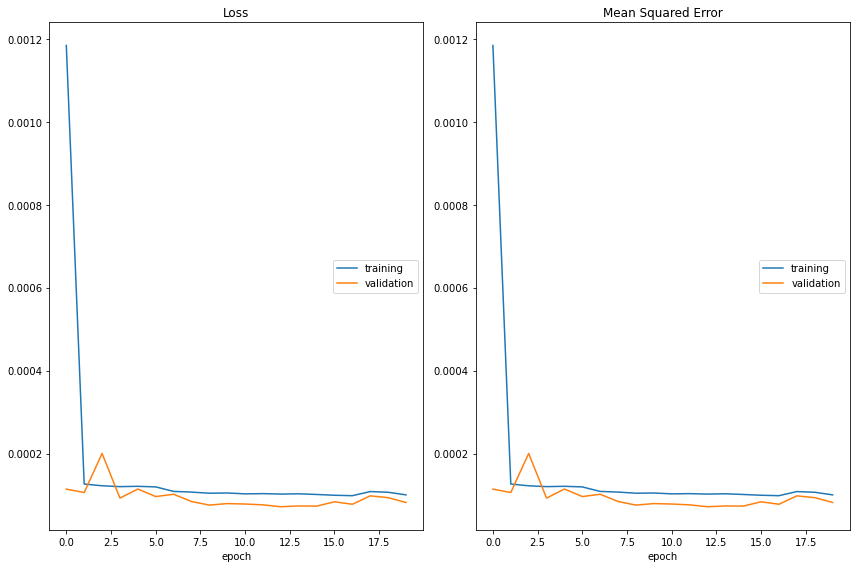

Loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Mean Squared Error
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
1862/1862 [==============================] - 6s 3ms/step - loss: 1.0027e-04 - mse: 1.0027e-04 - val_loss: 8.1939e-05 - val_mse: 8.1939e-05


In [8]:

from livelossplot import PlotLossesKerasTF


best_mlp_model = grid_search.best_estimator_



best_mlp_model.fit(X_train, y_train, epochs=20,
validation_data=(X_test, y_test),
callbacks=[PlotLossesKerasTF()], verbose=1)

### Análise de overfitting

Pelos gráficos, vemos que o medium average error (mae) dá bastante mal, mas o mse dá bem. Como 20 epochs é um valor considerável, consideramos nesta fase melhorar o tratamento de dados, e depois verificar se há melhorias. 
Isto porque, o tratamento de dados atual para este modelo é quase com o objetivo de o modelo consiguir analisar o dataset.

In [9]:
 #0btain predictions

start_time = time.time()
predictions = best_mlp_model.predict(X_test)
print("time - {}".format(time.time()-start_time))

predictions = unscale(predictions)
y_test = unscale(y_test)
#pd.DataFrame(y_test).hist(figsize=(14, 14));
#pd.DataFrame(predictions).hist(figsize=(14, 14));

#y_test_scaled = unscale(y_test)


466/466 [==============================] - 2s 4ms/step
time - 4.017726898193359


Mean Absolute Error:  68.3937852006578
Mean Squared Error:  18643.071885887744
RMSE:  136.53963485335584


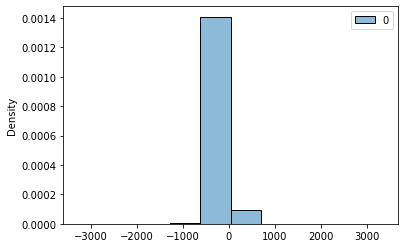

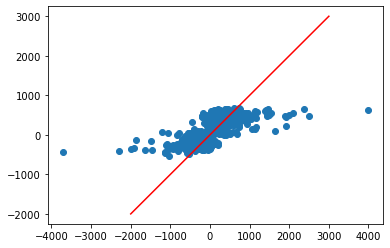

array([[175.95613 ],
       [ 37.144333],
       [ 37.144333],
       ...,
       [ 37.144333],
       [ 39.479904],
       [ 37.144333]], dtype=float32)

In [15]:
from sklearn import metrics

def analise_model(model): 
   
    #model.fit(X_train, y_train)
    #predictions = model.predict(X_test)
    
    #predictions  = predictions.reshape(len(predictions),1 )
    # Métricas
    print(model)
   # print(model.get_params())
    print("Mean Absolute Error: ", mean_absolute_error(y_test, predictions))
    print("Mean Squared Error: ", mean_squared_error(y_test, predictions, squared=True))
    print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    sns.histplot(y_test-predictions, bins=10,stat="density")
    plt.show()
    
    ax = plt.axes()
    ax.plot([-2000, -250, 0, 1500, 3000], [-2000, -250, 0, 1500, 3000], 'r')
    plt.scatter(y_test,predictions)
    plt.show()
    return predictions
    

analise_model(best_mlp_model)

#plt.scatter(y_test,predictions)
#plt.show()

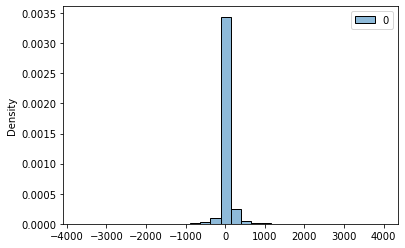

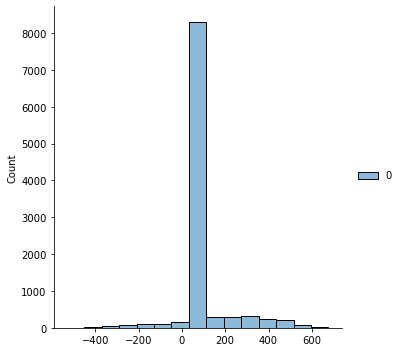

Quartis
[-3.70189280e+03  1.38555833e-13  9.23930000e+00  3.79986000e+01
  3.97908000e+03]


In [17]:
sns.histplot(y_test, bins=30,stat="density")
plt.show()
    
sns.displot(predictions)
plt.show() 

print("Quartis")
x = np.quantile(y_test, [0,0.25,0.5,0.75,1])

print(x)